In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from matplotlib import dates
import matplotlib.pyplot as plt
import time
from pathlib import Path
from tables import open_file
#
#
import ROOT as ROOT
import ctypes

%matplotlib inline

Welcome to JupyROOT 6.28/12


In [2]:
# Import hard DAMPE spectrum (0.1 - 6.3 TeV) for Protons
def DAMPE_proton_hard(energy, ekin_cutoff_min=0.01, ekin_cutoff_max=6.3):
    cutoff=np.int64(energy<ekin_cutoff_max)
    cutoff=cutoff*np.int64(energy>=ekin_cutoff_min)
    result = (0.0758*np.power(energy, -2.772) * np.power((1 + np.power((energy/0.48),5.0)), 0.0346))*cutoff
    return result

# Import soft DAMPE spectrum (6.3 - 100 TeV) for Protons
def DAMPE_proton_soft(energy, ekin_cutoff_min=6.3, ekin_cutoff_max=100):
    cutoff=np.int64(energy<ekin_cutoff_max)
    cutoff=cutoff*np.int64(energy>=ekin_cutoff_min)
    result = (0.0868*np.power(energy, -2.6) * np.power((1 + np.power((energy/13.6),5.0)), -0.05))*cutoff
    return result

# Import soft DAMPE spectrum (6.3 - 100 TeV) for Protons
def DAMPE_proton(energy):
    return DAMPE_proton_hard(energy) + DAMPE_proton_soft(energy)

def get_solid_angle(thetaDeg):
  return 2*np.pi*(1.0-np.cos(thetaDeg/180.0*np.pi))

def get_integral( ekin, rate_per_TeV, eMin_TeV, eMax_TeV, n_integral_points = 1000000):
    xx=np.linspace(eMin_TeV,eMax_TeV,n_integral_points)
    dx=xx[1]-xx[0]
    yy=np.interp(xx, ekin, rate_per_TeV)
    return np.sum(yy)*dx

In [3]:
def get_proton_rate( sim, trg, Rsim_m=1500, thetaSim_deg=10):
    ekin_min = 0.01  #TeV
    ekin_max = 100.0 #TeV
    n_log_bins = 100
    bins=np.logspace(np.log10(ekin_min),np.log10(ekin_max),n_log_bins)
    hist_sim=plt.hist( sim, bins=bins);
    hist_trg=plt.hist( trg, bins=bins);
    #
    energy_bins = (hist_sim[1][:-1] + hist_sim[1][1:])/2.0;
    nev_sim=hist_sim[0]
    nev_trg=hist_trg[0]
    #
    ekin=energy_bins
    rate_per_TeV_per_s=DAMPE_proton(ekin)*nev_trg/nev_sim*np.pi*Rsim_m*Rsim_m*get_solid_angle(thetaSim_deg)
    #
    proton_rate = get_integral( ekin, rate_per_TeV_per_s, ekin_min, ekin_max)
    #
    del(hist_sim)
    del(hist_trg)
    plt.close()
    #
    return proton_rate

In [4]:
def get_L1_DCR_tare( L1_max_digi_sum, dt_sim_s, threshold):
    time_tot_s = len(L1_max_digi_sum)*dt_sim_s
    return np.sum(np.int64(L1_max_digi_sum>threshold))/time_tot_s

In [5]:
def get_L1_L2_DCR_tare( L1_max_digi_sum, L2_iso_n_points, dt_sim_s, L1_threshold, L2_n_points):
    time_tot_s = len(L1_max_digi_sum)*dt_sim_s
    l1_is_ok=np.int64(L1_max_digi_sum>L1_threshold)
    l2_is_ok=np.int64(L2_iso_n_points>L2_n_points)
    return np.sum(l1_is_ok*l2_is_ok)/time_tot_s

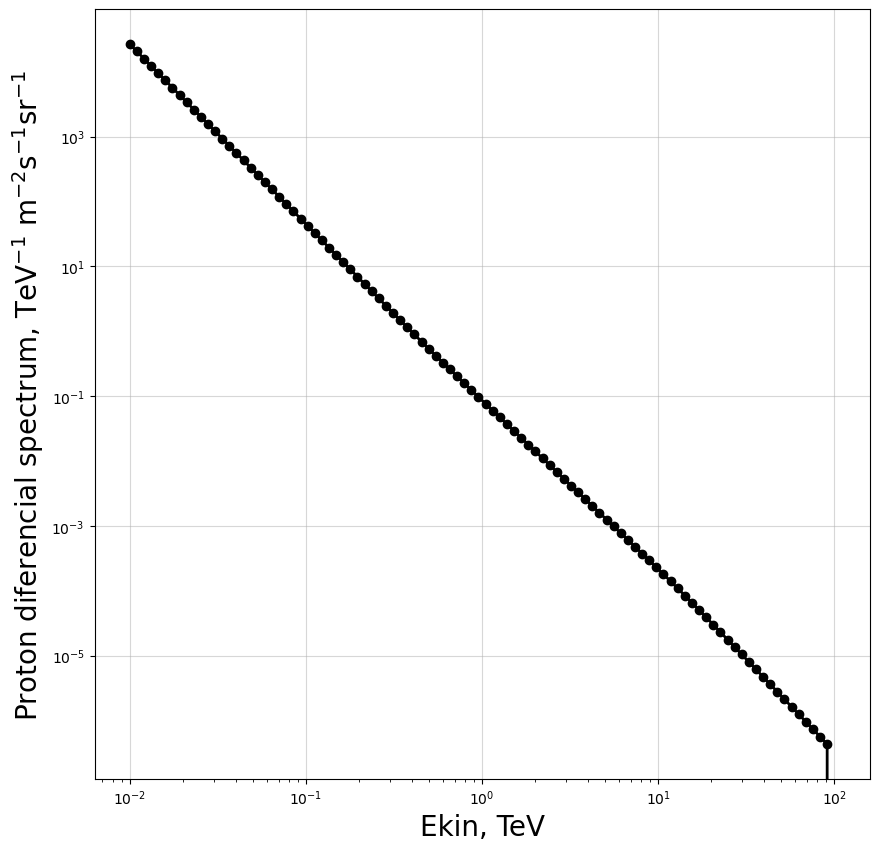

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

thefontsize=20

ax.set_ylabel('Proton diferencial spectrum, TeV$^{-1}$ m$^{-2}$s$^{-1}$sr$^{-1}$',fontsize=thefontsize)
ax.set_xlabel('Ekin, TeV',fontsize=thefontsize)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(-4,6);
#ax.set_ylim(-0.000001,0.000001);
#
ax.grid(True,alpha=0.5)
ekin=np.logspace(np.log10(0.01),np.log10(100.0),100)

ax.plot(ekin, 
        DAMPE_proton(ekin),
        lw=2, 
        color='black', 
        marker='o',
        label='data')

In [7]:
ncsvf=!(ls ../scratch/simtel_data/proton/npe/corsika_run*.npe.csv | wc -l)
ncsvf=int((ncsvf[0]))
fname_list=['../scratch/simtel_data/proton/npe/corsika_run' + str(i) + '.npe.csv' for i in range(1,ncsvf+1)]
df_list=[pd.read_csv(fname) for fname in fname_list]
#
df=pd.concat(df_list, ignore_index=True)
n_sim_ev_per_file = 1000000.0
n_sim_ev = len(df_list)*n_sim_ev_per_file
dt_one_wf_ns = 75*1000/1024.0
dt_one_wf_s = dt_one_wf_ns*1.0e-9
#
print("n_sim_ev     = ", n_sim_ev)
print("len(df_list) = ", len(df_list))
print("dt_one_wf_ns = ", dt_one_wf_ns)
print("dt_one_wf_s  = ", dt_one_wf_s)

n_sim_ev     =  426000000.0
len(df_list) =  426
dt_one_wf_ns =  73.2421875
dt_one_wf_s  =  7.324218750000001e-08


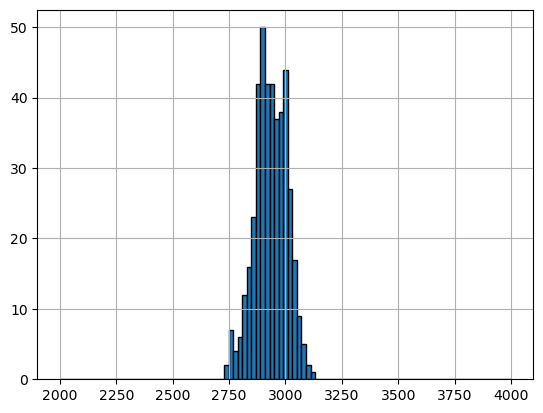

426


In [8]:
plt.hist(np.array([len(dftmp) for dftmp in df_list]), bins=np.linspace(2000.0, 4000, num=100), edgecolor='black', alpha=1.0)
plt.grid(True)
plt.show()
print(len(df_list))

In [9]:
df

,Unnamed: 0,event_id,energy,azimuth,altitude,h_first_int,xmax,hmax,emax,cmax,...,L3_cl_channelID_LST3,L3_cl_timeID_LST3,L3_cl_n_digitalsum_points_LST4,L3_cl_n_clusters_LST4,L3_cl_n_points_LST4,L3_cl_x_mean_LST4,L3_cl_y_mean_LST4,L3_cl_t_mean_LST4,L3_cl_channelID_LST4,L3_cl_timeID_LST4
0,0,5200.0,0.115086,3.062638,1.218684,16199.321289,273.076935,10251.343750,273.333344,278.034241,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,1,5208.0,0.115086,3.062638,1.218684,16199.321289,273.076935,10251.343750,273.333344,278.034241,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,2,5504.0,1.123066,3.220341,1.271500,12663.388672,457.200012,6639.671875,461.428558,460.637756,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,3,6409.0,0.122709,2.996659,1.231897,17323.265625,294.000000,9758.931641,294.000000,328.353088,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,4,7604.0,0.230914,3.106559,1.238464,13307.477539,516.086975,5728.506348,516.956543,458.041138,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249679,2833,9968301.0,0.655462,3.029138,1.208794,15159.474609,337.500000,8817.290039,334.666656,300.884735,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1249680,2834,9972704.0,2.421454,2.814749,1.269003,31757.238281,231.363632,11332.046875,231.333328,226.344101,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1249681,2835,9973603.0,0.903230,3.182498,1.352516,17908.154297,354.615387,8472.549805,354.000000,357.879913,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1249682,2836,9986905.0,0.249339,3.064357,1.168519,16672.931641,234.000000,11259.129883,233.157898,233.855255,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [10]:
df_20pe_DCR=df[df['n_pe_LST1']==20]
df_min20pe=df[df['n_pe_LST1']>=20]
df_min30pe=df[df['n_pe_LST1']>=30]
df_min40pe=df[df['n_pe_LST1']>=40]
df_min50pe=df[df['n_pe_LST1']>=50]
df_min60pe=df[df['n_pe_LST1']>=60]
df_min70pe=df[df['n_pe_LST1']>=70]
df_min80pe=df[df['n_pe_LST1']>=80]
df_min90pe=df[df['n_pe_LST1']>=90]
df_min100pe=df[df['n_pe_LST1']>=100]
df_min110pe=df[df['n_pe_LST1']>=110]
df_trg_l1=df[df['L1_max_digi_sum_LST1']>14963]
df_trg_l2=df_trg_l1[df_trg_l1['L3_iso_n_points_LST1']>7]
#df_trg_l1_20pe_DCR=df_20pe_DCR[df_20pe_DCR['L1_max_digi_sum_LST1']>14963]
#df_trg_l2_20pe_DCR=df_trg_l1_20pe_DCR[df_trg_l1_20pe_DCR['L3_iso_n_points_LST1']>7]

In [11]:
sim=1.0/np.random.uniform(1.0/100,1.0/0.01,int(n_sim_ev)) 
trg=df_min20pe['energy'].values
print(get_proton_rate( sim, trg))

55611.39251452843


In [12]:
print(get_proton_rate( sim, df_trg_l1['energy'].values))

27797.411871911114


In [12]:
tic = time.time()
print(get_proton_rate( sim, df_trg_l2['energy'].values))
toc = time.time()
print('Elapsed: %s' % (toc - tic))

7263.138559378137
Elapsed: 21.103116035461426


In [13]:
proton_rate_l1_r=[]
proton_rate_l1_th=[]
proton_rate_l1_t=[]
for th in np.arange(14960,15300,10):
    tic = time.time()
    df_trg_l1_tmp=df[df['L1_max_digi_sum_LST1']>th]
    pr=get_proton_rate( sim, df_trg_l1_tmp['energy'].values)
    toc = time.time()
    dt=toc-tic
    #
    proton_rate_l1_r.append(pr)
    proton_rate_l1_th.append(th)
    proton_rate_l1_t.append(dt)
    #
    print('Rate: ', pr, ' Time : ',dt)

df_proton_rate_l1 = pd.DataFrame({
    'pr': np.array(proton_rate_l1_r),
    'th': np.array(proton_rate_l1_th),
    't': np.array(proton_rate_l1_t)
})

Rate:  30125.02856898786  Time :  21.30657458305359
Rate:  23200.918106931364  Time :  21.232699155807495
Rate:  18580.397638664846  Time :  21.307375192642212
Rate:  15596.833464882926  Time :  21.250831842422485
Rate:  13705.761965927864  Time :  21.461263418197632
Rate:  12420.159071279828  Time :  21.22929573059082
Rate:  11478.766618694455  Time :  21.249588012695312
Rate:  10723.6432613365  Time :  21.12944006919861
Rate:  10111.474457578675  Time :  21.087358474731445
Rate:  9577.722451758258  Time :  21.184725284576416
Rate:  9092.456905588937  Time :  21.17242455482483
Rate:  8668.271476148799  Time :  21.185177087783813
Rate:  8282.703333094729  Time :  21.183501482009888
Rate:  7928.222662050732  Time :  21.162776708602905
Rate:  7597.677464562576  Time :  21.06329345703125
Rate:  7277.915594534348  Time :  21.13879132270813
Rate:  7003.103778081384  Time :  21.12240481376648
Rate:  6747.15153268633  Time :  21.217610359191895
Rate:  6500.754740855531  Time :  21.27226018905

In [14]:
df_proton_rate_l1

,pr,th,t
0,30125.028569,14960,21.306575
1,23200.918107,14970,21.232699
2,18580.397639,14980,21.307375
3,15596.833465,14990,21.250832
4,13705.761966,15000,21.461263
5,12420.159071,15010,21.229296
6,11478.766619,15020,21.249588
7,10723.643261,15030,21.129440
8,10111.474458,15040,21.087358
9,9577.722452,15050,21.184725


In [15]:
proton_rate_l2_r=[]
proton_rate_l2_th=[]
proton_rate_l2_t=[]
for th in np.arange(14960,15300,10):
    tic = time.time()
    df_trg_l1_tmp=df[df['L1_max_digi_sum_LST1']>th]
    df_trg_l2_tmp=df_trg_l1_tmp[df_trg_l1_tmp['L3_iso_n_points_LST1']>7]
    pr=get_proton_rate( sim, df_trg_l2_tmp['energy'].values)
    toc = time.time()
    dt=toc-tic
    #
    proton_rate_l2_r.append(pr)
    proton_rate_l2_th.append(th)
    proton_rate_l2_t.append(dt)
    #
    print('Rate: ', pr, ' Time : ',dt)

df_proton_rate_l2 = pd.DataFrame({
    'pr': np.array(proton_rate_l2_r),
    'th': np.array(proton_rate_l2_th),
    't': np.array(proton_rate_l2_t)
})

Rate:  7272.997531523684  Time :  21.324623584747314
Rate:  7236.847085079851  Time :  21.263699293136597
Rate:  7200.652083695377  Time :  21.44766902923584
Rate:  7163.940102253455  Time :  21.281150579452515
Rate:  7127.6989891849225  Time :  21.20246720314026
Rate:  7087.577889005888  Time :  21.28324866294861
Rate:  7046.375115023551  Time :  21.270352363586426
Rate:  6995.684909182089  Time :  21.224318981170654
Rate:  6936.568597097433  Time :  21.331549644470215
Rate:  6868.874959133661  Time :  21.165181875228882
Rate:  6795.307877248462  Time :  21.24365258216858
Rate:  6714.233027232654  Time :  21.125436782836914
Rate:  6625.829669880481  Time :  21.242048501968384
Rate:  6524.164786950647  Time :  21.341540575027466
Rate:  6416.576608765388  Time :  21.276238918304443
Rate:  6299.189258407476  Time :  21.144683837890625
Rate:  6182.7547198222355  Time :  21.192750692367554
Rate:  6057.319170638812  Time :  21.09367346763611
Rate:  5930.001830099218  Time :  21.151039361953

In [16]:
df_proton_rate_l2

,pr,th,t
0,7272.997532,14960,21.324624
1,7236.847085,14970,21.263699
2,7200.652084,14980,21.447669
3,7163.940102,14990,21.281151
4,7127.698989,15000,21.202467
5,7087.577889,15010,21.283249
6,7046.375115,15020,21.270352
7,6995.684909,15030,21.224319
8,6936.568597,15040,21.331550
9,6868.874959,15050,21.165182


In [27]:
df_proton_rate_l1.to_csv('df_proton_rate_l1_format.csv', index=False, header=False, sep=' ')
df_proton_rate_l2.to_csv('df_proton_rate_l2_format.csv', index=False, header=False, sep=' ')
df_proton_rate_l1.to_csv('df_proton_rate_l1.csv')
df_proton_rate_l2.to_csv('df_proton_rate_l2.csv')

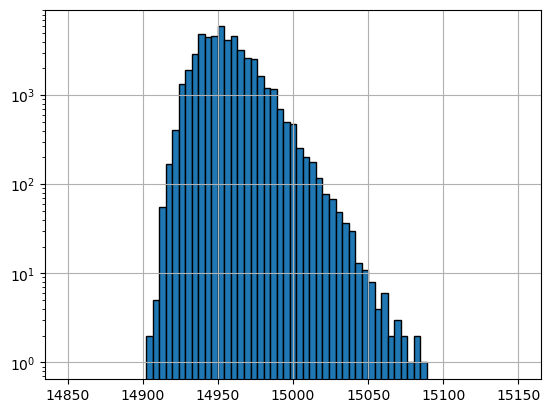

In [17]:
plt.hist(df_20pe_DCR['L1_max_digi_sum_LST1'].values, bins=np.linspace(14850, 15150, num=70), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

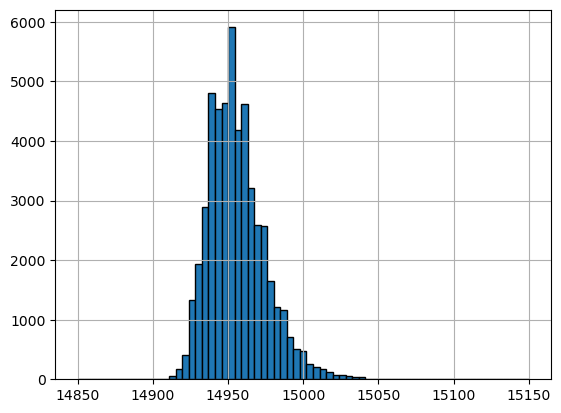

In [18]:
plt.hist(df_20pe_DCR['L1_max_digi_sum_LST1'].values, bins=np.linspace(14850, 15150, num=70), edgecolor='black', alpha=1.0)
#plt.yscale('log')
plt.grid(True)
plt.show()

In [30]:
threshold=np.arange(14800,15100,1)
rate_DCR_L1=[ get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=threshold) for threshold in np.arange(14800,15100,1)]

In [80]:
rate_DCR_L1_L2=[ get_L1_L2_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, L2_iso_n_points=df_20pe_DCR['L3_cl_n_points_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, L1_threshold=threshold, L2_n_points=25)for threshold in np.arange(14800,15100,1)]

In [81]:
#get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=15085)
#threshold=np.arange(14800,15100,1)
#rate_DCR_L1=[ get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=threshold) for threshold in np.arange(14800,15100,1)]
#get_L1_DCR_tare( L1_max_digi_sum=df_20pe_DCR['L1_max_digi_sum_LST1'].values, dt_sim_s=75*1000.0/1024.0*1.0e-9, threshold=15085)

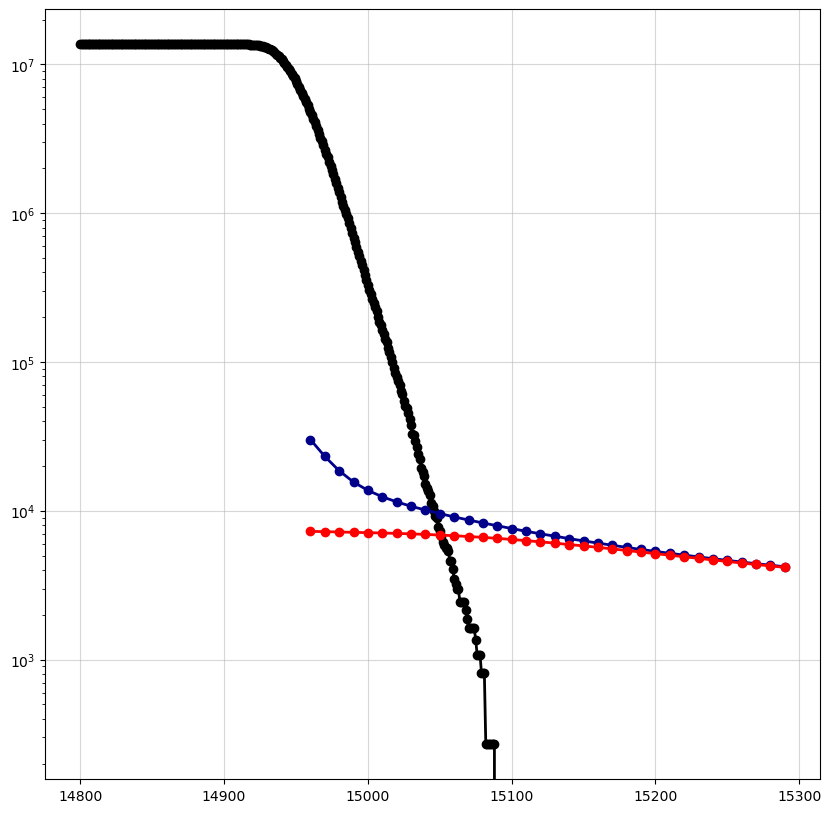

In [86]:
fig, ax = plt.subplots(figsize=(10,10))

thefontsize=20

#ax.set_ylabel('Proton rate, TeV$^{-1}$ s$^{-1}$',fontsize=thefontsize)
#ax.set_xlabel('Ekin, TeV',fontsize=thefontsize)
#ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(-4,6);
#ax.set_ylim(-0.000001,0.000001);
#
ax.grid(True,alpha=0.5)
#ekin=df_LSTsipm_protons_sim['energy'].values
#rate_per_TeV_per_s=DAMPE_proton(ekin)*df_LSTsipm_protons_trg110pe['nev'].values/df_LSTsipm_protons_sim['nev'].values*np.pi*1500*1500*get_solid_angle(10)

ax.plot(threshold, 
        rate_DCR_L1,
        lw=2, 
        color='black', 
        marker='o',
        label='data')

ax.plot(threshold, 
        rate_DCR_L1_L2,
        lw=2, 
        color='darkred', 
        marker='o',
        label='data')

ax.plot(df_proton_rate_l1['th'].values, 
        df_proton_rate_l1['pr'].values,
        lw=2, 
        color='darkblue', 
        marker='o',
        label='data')

ax.plot(df_proton_rate_l2['th'].values, 
        df_proton_rate_l2['pr'].values,
        lw=2, 
        color='red', 
        marker='o',
        label='data')

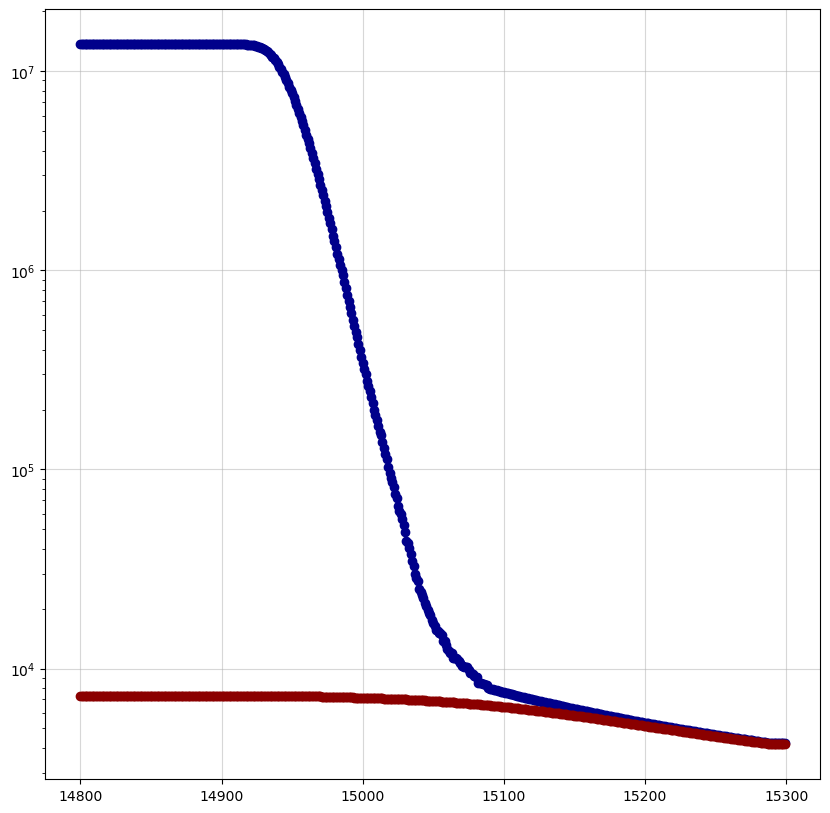

In [83]:
threshold_sum=np.arange(14800,15300,1)

rate_L1=np.interp( threshold_sum, threshold, rate_DCR_L1) + np.interp(threshold_sum, df_proton_rate_l1['th'].values, df_proton_rate_l1['pr'].values)
rate_L1_L2=np.interp( threshold_sum, threshold, rate_DCR_L1_L2) + np.interp(threshold_sum, df_proton_rate_l2['th'].values, df_proton_rate_l2['pr'].values)


fig, ax = plt.subplots(figsize=(10,10))

thefontsize=20

#ax.set_ylabel('Proton rate, TeV$^{-1}$ s$^{-1}$',fontsize=thefontsize)
#ax.set_xlabel('Ekin, TeV',fontsize=thefontsize)
#ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(-4,6);
#ax.set_ylim(-0.000001,0.000001);
#
ax.grid(True,alpha=0.5)
#ekin=df_LSTsipm_protons_sim['energy'].values
#rate_per_TeV_per_s=DAMPE_proton(ekin)*df_LSTsipm_protons_trg110pe['nev'].values/df_LSTsipm_protons_sim['nev'].values*np.pi*1500*1500*get_solid_angle(10)

#ax.plot(threshold, 
#        rate_DCR_L1,
#        lw=2, 
#        color='black', 
#        marker='o',
#        label='data')

ax.plot(threshold_sum, 
        rate_L1,
        lw=2, 
        color='darkblue', 
        marker='o',
        label='data')

ax.plot(threshold_sum, 
        rate_L1_L2,
        lw=2, 
        color='darkred', 
        marker='o',
        label='data')


#ax.plot(df_proton_rate_l2['th'].values, 
#        df_proton_rate_l2['pr'].values,
#        lw=2, 
#        color='red', 
#        marker='o',
#        label='data')

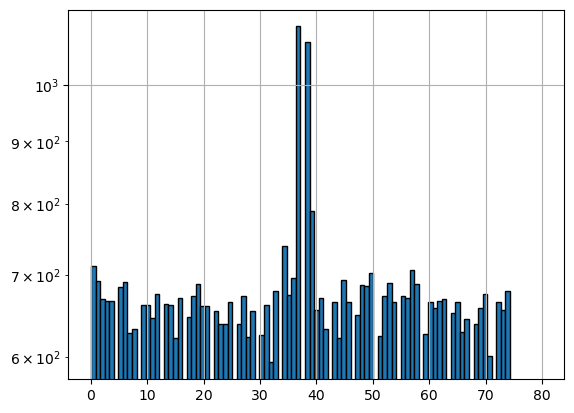

50656


In [84]:
plt.hist(df_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
#plt.hist(df_trg_l1_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
#plt.hist(df_trg_l2_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()
print(len(df_20pe_DCR['L1_t_mean_LST1']))
#print(len(df_trg_l1_20pe_DCR['L1_t_mean_LST1']))

In [87]:
plt.hist(df_trg_l1_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
plt.hist(df_trg_l2_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 80, num=100), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

NameError: name 'df_trg_l1_20pe_DCR' is not defined

In [ ]:
plt.hist(df['L1_t_mean_LST1'].values, bins=np.linspace(45, 80, num=1000), edgecolor='black', alpha=1.0);
#plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
plt.hist(df_trg_l1['L1_t_mean_LST1'].values, bins=np.linspace(0, 75, num=76), edgecolor='black', alpha=1.0)
plt.hist(df_min110pe['L1_t_mean_LST1'].values, bins=np.linspace(0, 75, num=76), edgecolor='black', alpha=1.0)
plt.hist(df_20pe_DCR['L1_t_mean_LST1'].values, bins=np.linspace(0, 75, num=76), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
plt.hist(df_20pe_DCR['L1_max_digi_sum_LST1'].values, bins=np.linspace(14000, 16000, num=76), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
#14963 and L3 n points is > 7
df_trg_l1=df[df['L1_max_digi_sum_LST1']>14963]
df_trg_l2=df_trg_l1[df_trg_l1['L3_iso_n_points_LST1']>7]

In [ ]:
hist_sim=plt.hist(1.0/np.random.uniform(1.0/100,1.0/0.01,int(n_sim_ev)), 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg20pe=plt.hist(df_min20pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg30pe=plt.hist(df_min30pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg40pe=plt.hist(df_min40pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg50pe=plt.hist(df_min50pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg60pe=plt.hist(df_min60pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg70pe=plt.hist(df_min70pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg80pe=plt.hist(df_min80pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg90pe=plt.hist(df_min90pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg100pe=plt.hist(df_min100pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg110pe=plt.hist(df_min110pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
#
hist_trg=plt.hist(df_trg_l2['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), alpha=1.0)
#
plt.xlabel('energy, TeV')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

In [ ]:
df_LSTsipm_protons_sim = pd.DataFrame({
    'energy': (hist_sim[1][:-1] + hist_sim[1][1:])/2.0,
    'nev': hist_sim[0]
})
df_LSTsipm_protons_trg = pd.DataFrame({
    'energy': (hist_trg[1][:-1] + hist_trg[1][1:])/2.0,
    'nev': hist_trg[0]
})
#
df_LSTsipm_protons_trg20pe = pd.DataFrame({
    'energy': (hist_trg20pe[1][:-1] + hist_trg20pe[1][1:])/2.0,
    'nev': hist_trg20pe[0]
})
df_LSTsipm_protons_trg30pe = pd.DataFrame({
    'energy': (hist_trg30pe[1][:-1] + hist_trg30pe[1][1:])/2.0,
    'nev': hist_trg30pe[0]
})
df_LSTsipm_protons_trg40pe = pd.DataFrame({
    'energy': (hist_trg40pe[1][:-1] + hist_trg40pe[1][1:])/2.0,
    'nev': hist_trg40pe[0]
})
df_LSTsipm_protons_trg50pe = pd.DataFrame({
    'energy': (hist_trg50pe[1][:-1] + hist_trg50pe[1][1:])/2.0,
    'nev': hist_trg50pe[0]
})
df_LSTsipm_protons_trg60pe = pd.DataFrame({
    'energy': (hist_trg60pe[1][:-1] + hist_trg60pe[1][1:])/2.0,
    'nev': hist_trg60pe[0]
})
df_LSTsipm_protons_trg70pe = pd.DataFrame({
    'energy': (hist_trg70pe[1][:-1] + hist_trg70pe[1][1:])/2.0,
    'nev': hist_trg70pe[0]
})
df_LSTsipm_protons_trg80pe = pd.DataFrame({
    'energy': (hist_trg80pe[1][:-1] + hist_trg80pe[1][1:])/2.0,
    'nev': hist_trg80pe[0]
})
df_LSTsipm_protons_trg90pe = pd.DataFrame({
    'energy': (hist_trg90pe[1][:-1] + hist_trg90pe[1][1:])/2.0,
    'nev': hist_trg90pe[0]
})
df_LSTsipm_protons_trg100pe = pd.DataFrame({
    'energy': (hist_trg100pe[1][:-1] + hist_trg100pe[1][1:])/2.0,
    'nev': hist_trg100pe[0]
})
df_LSTsipm_protons_trg110pe = pd.DataFrame({
    'energy': (hist_trg110pe[1][:-1] + hist_trg110pe[1][1:])/2.0,
    'nev': hist_trg110pe[0]
})
#
#
#df_LSTsipm_protons_sim.to_csv('LST_AdvCam_Zenith_20.00deg_proton_sim.csv', index=False, header=False, sep=' ')
#df_LSTsipm_protons_trg.to_csv('LST_AdvCam_Zenith_20.00deg_proton_trg.csv', index=False, header=False, sep=' ')
#df_LSTsipm_protons_trg['nev'].values/df_LSTsipm_protons_sim['nev'].values

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

thefontsize=20

ax.set_ylabel('Proton rate, TeV$^{-1}$ s$^{-1}$',fontsize=thefontsize)
ax.set_xlabel('Ekin, TeV',fontsize=thefontsize)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(-4,6);
#ax.set_ylim(-0.000001,0.000001);
#
ax.grid(True,alpha=0.5)
ekin=df_LSTsipm_protons_sim['energy'].values
rate_per_TeV_per_s=DAMPE_proton(ekin)*df_LSTsipm_protons_trg110pe['nev'].values/df_LSTsipm_protons_sim['nev'].values*np.pi*1500*1500*get_solid_angle(10)

ax.plot(ekin, 
        rate_per_TeV_per_s,
        lw=2, 
        color='black', 
        marker='o',
        label='data')

print(get_integral( ekin, rate_per_TeV_per_s, 0.01, 100))

#print("nterp ",np.interp([10,20], ekin, rate_per_TeV_per_s))

In [ ]:
#
hist_trg=plt.hist(df_trg_l2['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
#
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()
#

In [ ]:
plt.hist(df['L1_t_mean_LST1'].values, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.5)
plt.hist(df_trg_l2['L3_cl_t_mean_LST1'].values*1.0/0.06, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.7)
plt.xlabel('time tic')
#plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
plt.hist(df['L1_t_mean_LST1'].values, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.5)
plt.hist(df_trg_l2['L3_cl_t_mean_LST1'].values*1.0/0.06, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.7)
plt.xlabel('time tic')
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
thehist=plt.hist(np.random.uniform(0.02,20,1000000), bins=np.logspace(np.log10(0.02),np.log10(20.0),16), edgecolor='black', alpha=1.0)
#plt.hist(np.random.uniform(0.02,20,10000), bins=np.linspace(0.02,20,16), edgecolor='black', alpha=1.0)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [ ]:
thehist

In [ ]:
plt.hist(df['L1_max_digi_sum_LST1'].values, bins=np.logspace(np.log10(10000),np.log10(100000.0),100), edgecolor='black', alpha=0.5)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [ ]:
plt.hist(df['L1_max_digi_sum_LST1'].values, bins=np.linspace(14800,16000,100), edgecolor='black', alpha=0.5)
plt.yscale('log')   # Set y-axis to logarithmic scale
#plt.xscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [ ]:
len(df['L1_max_digi_sum_LST1'])

In [ ]:
np.linspace(0,1,10)